# Classification de documents : prise en main des outils

Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.


## Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le corpus tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
1. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... <BR>
    **L'utilité dépend de l'application!**
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
1. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
1. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

## Exploitation de la chaine de traitement

On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
1. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
1. Collecter et analyser les résultats


## Inférence

L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents

# Etape 1: charger les données

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path

In [2]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs


In [3]:
fname = "AFDpresidentutf8/corpus.tache1.learn.utf8"

alltxts,alllabs = load_pres(fname)


In [ ]:
fname = "AFDpresidentutf8/corpus.tache1.test.utf8"

alltxts_test,alllabs_test = load_pres(fname)

In [4]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])



57413 57413
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

1
 Je compte sur vous.

1


In [5]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs


In [6]:
path = "AFDmovies/movies1000/"

alltxts,alllabs = load_movies(path)

In [7]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])

2000 2000
lucas was wise to start his star wars trilogy with episode 4 : episode 1 is a boring , empty spectacle that features some nice special effects . 
after the familiar 'a long time ago . . . . ' 
opening , the film starts with the opening yellow crawl that features in every star wars movie and computer game . 
the plot is that the trade confederation are blocking off supplies to the peaceful planet of naboo , ruled by queen amidala ( portman ) jedi knights qui-gon ( neeson ) and obi wan ( mcgregor ) are sent to negotiate a deal with the confederation to stop the blockade . 
however , this simple blockade is not all it seems , and the jedi knights soon have to deal with many more dangers , including facing the evil darth maul ( ray park . ) 
they also meet the future darth vadar , anakin skywalker ( jake lloyd ) 
star wars is largely a failure in all the major areas of filmmaking : script , direction and characters . 
the script desperately tries to make an thin and boring story 

# Transformation paramétrique du texte

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [31]:
# récupération de la ponctuation
import string
import re
from nltk.stem import PorterStemmer
from wordcloud import STOPWORDS 
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer

def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

token_pattern = r"(?u)\b\w\w+\b|\S+" # pour garder la ponctuation

tokenizer = CountVectorizer(lowercase = False,token_pattern = token_pattern).build_tokenizer()

# ligne : -2 = resumé, ligne = 0 : titre
def preprocessing(x,params = dict()):
    
    """
        params: dictionnaire de valeurs avec 
        lowercase,strip_accents,marker,number,stemming,ligne,stopwords
    """
    global tokenizer
    
    
    # si ligne != None récupère la ligne indiqué
    if params.get("ligne",None) is not None:
        x = x.split('\n')[params["ligne"]]
        
    if params.get("strip_accents",False):
        x = strip_accents(x)
        
    # si fuse => fusionne les mots avec une ponctuation au milieu
    if params.get("punct",False) == "fuse":
        punc = string.punctuation  # recupération de la ponctuation
        x = x.translate(str.maketrans('', '', punc))
        
    # si strip_accents => supprime la ponctuation
    if params.get("punct",False) == "separe":
        punc = string.punctuation  # recupération de la ponctuation
        punc += '\n\r\t'
        x = x.translate(str.maketrans(punc, ' ' * len(punc)))  
    
    if params.get("number",False):
        x = re.sub('[0-9]+', '', x) # remplacer une séquence de chiffres par rien
        
    tokens = tokenizer(x)
    # --- token users

        
    if params.get("marker",False):
        x = " ".join(["@" if str.isupper(token) else token for token in tokens])
        tokens = tokenizer(x)

    # si stopwords != None suppression des mots pas dans le dictionnaire
    if params.get("stopwords",False):
        # tokens = [ token for token in tokens if token not in params["stopwords"] or token in string.punctuation]
        x = " ".join([token for token in tokens if token not in params["stopwords"]])
        
    if params.get("stemming",False):
        ps = PorterStemmer()
        x = " ".join([ps.stem(i) for i in tokens])
        tokens = tokenizer(x)
    
    # ---
    if params.get("lowercase",False):
        x = x.lower()
    
        
    return x

In [33]:
params = {
    "lowercase":False,
    "punct":False,
    "marker":False,
    "number":False,
    "stemming":False,
    "ligne": None,
    "strip_accents":False,
    "stopwords": set(STOPWORDS)
}
print("original :")
print(alltxts[0])
print("result :")
preprocessing(alltxts[0],params)

original :
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

result :


"Quand je dis chers amis , il ne s'agit pas là d'une formule diplomatique , mais de l'expression de ce que je ressens ."

In [35]:

params = {
    "lowercase":False,
    "marker":False,
    "number":False,
    "stemming":False,
    "ligne": None,
    "punct":False,
    "strip_accents":False,
    "stopwords": None
}
f = lambda x: preprocessing(x,params)
                            
vectorizer = CountVectorizer(preprocessor = f,lowercase=False,token_pattern = token_pattern)
X = vectorizer.fit_transform(alltxts)

# Extraction du vocabulaire

Exploration préliminaire des jeux de données.

- Quelle est la taille d'origine du vocabulaire?
- Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
- Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
- Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
- Quelle est la distribution d'apparition des mots (Zipf)
- Quels sont les 100 bigrammes/trigrammes les plus fréquents?


In [13]:
len(vectorizer.get_feature_names())

39659

In [14]:
np.sum(X.toarray())

1259869

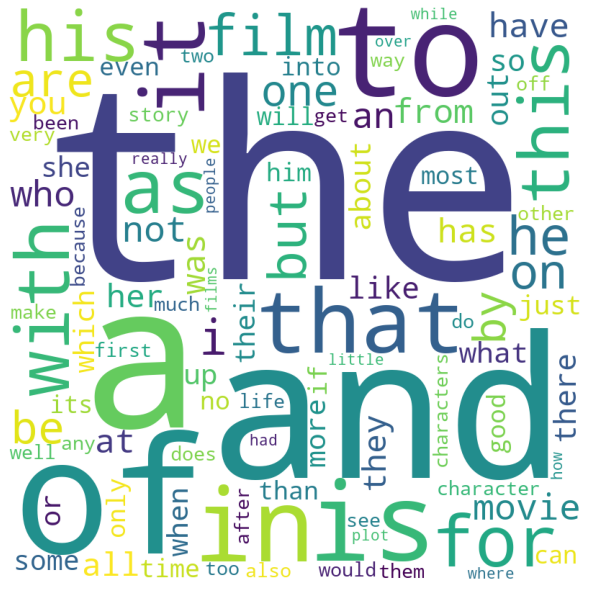

In [192]:
# frequence
from wordcloud import WordCloud, STOPWORDS 
        
wordcloud_base = WordCloud(width = 800, height = 800, 
                background_color ='white',max_words=100,stopwords = [],collocations = False,normalize_plurals = False, include_numbers = True)

wordcloud = wordcloud_base.generate(" ".join(alltxts)) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [165]:
# oddsratio
class OddsRatioCloud:
    def __init__(self,datax,datay,lower = True, # si on lower
                 stopwords = None, # mots à ne pas regarder
                 letters_numbers = False, # si supprime caractères non lettres/chiffres
                 numbers = True, # si supprime nombres
                 min_appear = 0, # nombre de fois que le mot doit apparaitre (borne non incluse)
                 singular = True, # si passage au singulier des mots 
                 lambd = 1 # on suppose lambd élément dans chaque classe
                 ):
        self.lower = lower
        self.stopwords = stopwords
        self.letters_numbers = letters_numbers
        self.numbers = numbers
        self.min_appear = min_appear
        self.datax = datax
        self.datay = datay
        self.singular = singular
        self.lambd = lambd
        
    def traitement(self,x):
        if self.lower: 
            x = x.lower()
        if self.letters_numbers:
            x = re.sub(r'[\W_ ]+','',x)
        if not self.numbers:
            x = re.sub(r"\d+","",x)
        if self.singular:
            if len(x) > 1 and x[-1] == 's' and x[-2] != 's':
                x = x[:-1]
        return x
    
    def _add_to_dicts(self,x,y,yplus,ymoins,dictio_yplus,dictio_ymoins,dictio_total):
        try:
            dictio_total[x] += 1
        except KeyError:
            dictio_total[x] = 1
        if y == yplus:
            try:
                dictio_yplus[x] += 1
            except KeyError:
                dictio_yplus[x] = 1
        elif ymoins is None or ymoins == y:
            try:
                dictio_ymoins[x] += 1
            except KeyError:
                dictio_ymoins[x] = 1
                
    def _get_result(self,dictio_total,dictio_yplus,dictio_ymoins,total):
        res = []
        tot_yplus = sum(dictio_yplus.values())
        tot_ymoins = sum(dictio_ymoins.values())
        for m,tot in dictio_total.items():
            nbm = dictio_ymoins.get(m,0)
            nbp = dictio_yplus.get(m,0)
            if tot <= self.min_appear:
                continue
            p = (nbp+self.lambd)/(tot_yplus+total*self.lambd)
            q = (nbm+self.lambd)/(tot_ymoins+total*self.lambd) # suppose apparait au moins une fois dans l'autre
            res += [(m,(p*(1-q))/(q*(1-p)),tot)]
        res = sorted(res, key = lambda x:x[1],reverse = True)
        return res
    def print_res(self,res):
        def transforme(tab):
            res = dict()
            for mot,odds,nb in tab:
                res[mot] = odds
            return res

        res = transforme(res)
        # utilise frequence des mots dans l'ordre
        wordcloud_base = WordCloud(width = 800, height = 800, 
                background_color ='white',max_words=200)

        test = wordcloud_base.generate_from_frequencies(res)
        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.imshow(test) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
  
        plt.show() 
        
    def init(self,
            yplus, # le tag à regardé
            ymoins = None, # le tag à regardé si yplus faux, on met None si tout le reste
            print_res = True # affichage du resultats
            
            ):
        dictio_yplus = dict()
        dictio_ymoins = dict()
        dictio_total = dict()
        
        dictio_yplus_bi = dict()
        dictio_ymoins_bi = dict()
        dictio_total_bi = dict()
        for i,(x,y) in enumerate(zip(datax,datay)):
            
            if self.stopwords is not None and x.lower() in self.stopwords:
                continue
            x = self.traitement(x)
            if x == "":
                continue
            self._add_to_dicts(x, y, yplus, ymoins, dictio_yplus, dictio_ymoins, dictio_total)
            if i == len(datax) - 1: continue   
            x2 = datax[i+1]
            y2 = datay[i+1]
            if y2 != y: continue # pas dans la même phrase
            if stopwords is not None and x2.lower() in stopwords:
                continue
            x2 = self.traitement(x2)
            if x2 == "":
                continue
            bigram = x + " " + x2
            self._add_to_dicts(bigram, y, yplus, ymoins, dictio_yplus_bi, dictio_ymoins_bi, dictio_total_bi)
        
        total = len(dictio_total_bi) + len(dictio_total)
        res = self._get_result(dictio_total,dictio_yplus,dictio_ymoins,total)
        res_2 = self._get_result(dictio_total_bi,dictio_yplus_bi,dictio_ymoins_bi,total)
        if print_res:
            res_final = res  # +res_2
            self.print_res(res_final)
        return res, res_2

In [193]:
datax = []
datay = []

for phrase, l in zip(alltxts,alllabs):
    mots = phrase.split(" ")
    for mot in mots:
        datax+=[mot]
        datay+=[l]

stopwords = set(STOPWORDS)
min_appear = 5

cloud = OddsRatioCloud(datax, datay, 
                     lower=False, 
                     stopwords=[], 
                     letters_numbers = False, 
                     numbers = False, 
                     min_appear = 10,
                     lambd = 10e-3)


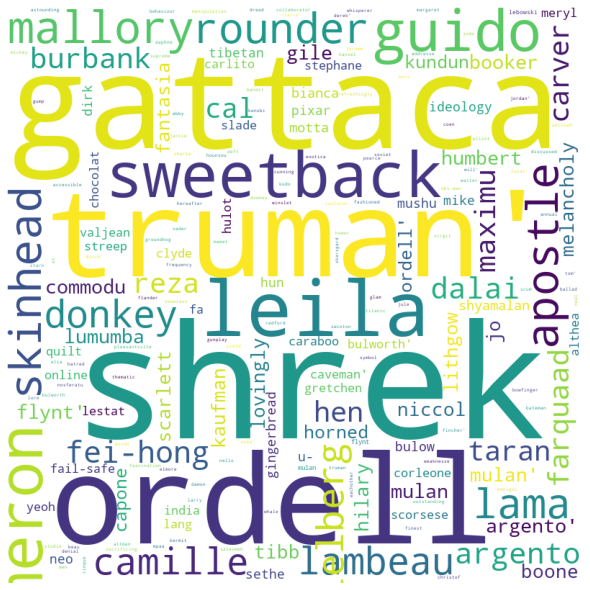

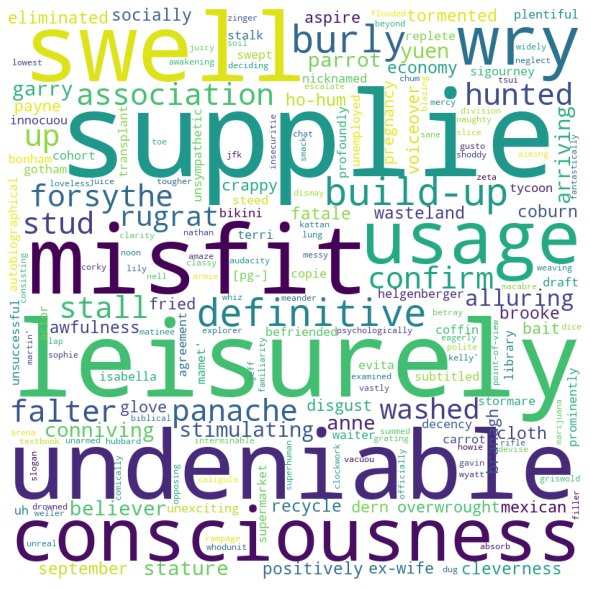

In [194]:
# oddsratio
res, res_2 = cloud.init(1)

res, res_2 = cloud.init(-1)

In [197]:
res = dict()

for phrase in alltxts:
    mots = phrase.split(" ")
    for mot in mots:
        try:
            res[mot]+=1
        except KeyError:
            res[mot]=1
        


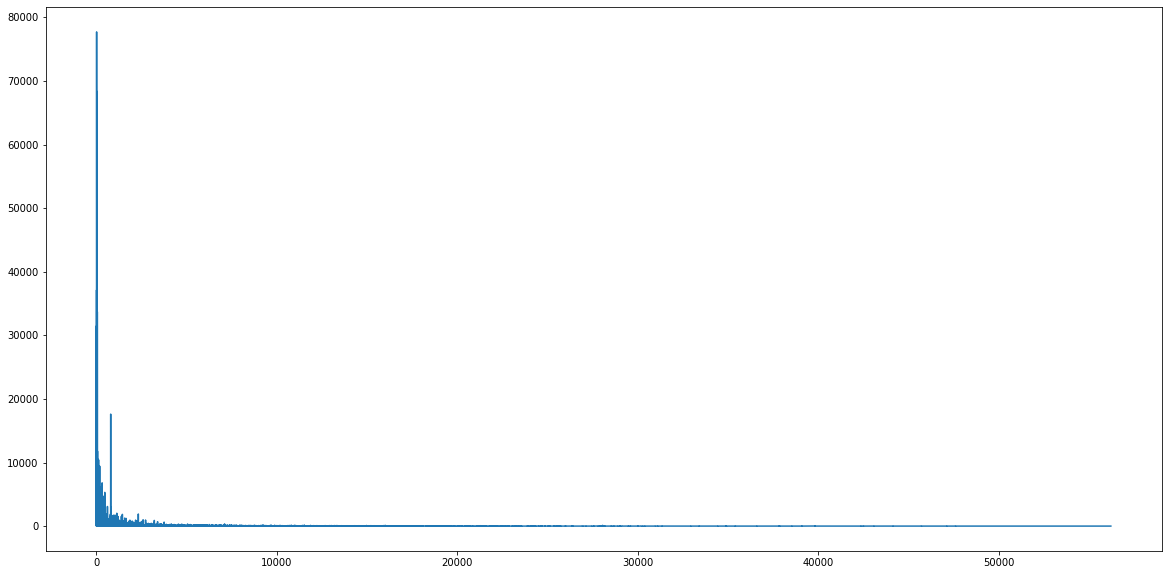

In [198]:
plt.figure(figsize=(20,10))
plt.plot(res.values())
plt.show()

Question qui devient de plus en plus intéressante avec les approches modernes:
est-il possible d'extraire des tri-grammes de lettres pour représenter nos documents?

Quelle performances attendrent? Quels sont les avantages et les inconvénients d'une telle approche?

# Modèles de Machine Learning

Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

In [36]:
import numpy as np
import sklearn.naive_bayes as nb
from sklearn import svm
from sklearn import linear_model as lin


# SVM => Penser à utiliser des SVM linéaire !!!!
clf = svm.LinearSVC()
# Naive Bayes
# clf = nb.MultinomialNB() # frequentiels
# regression logistique
# clf = lin.LogisticRegression()

# apprentissage
clf.fit(X, alllabs)  
yhat = clf.predict(X[-10].toarray()) # usage sur une nouvelle donnée

print("prédiction:",yhat)
print("classifieur:",clf.coef_) # pour rentrer dans le classifieur... Depend évidemment du classifieur!

prédiction: [1]
classifieur: [[ 0.08875449 -0.64791003 -0.2930772  ... -1.04872992  0.
  -0.22754856]]


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [37]:
clf.score(X,alllabs)

0.9878424747008517

In [38]:
# Solution 1 pour l'évaluation: validation croisée classique intégrée

from sklearn.model_selection import cross_val_score

# usage en boucle implicite
# le classifieur est donné en argument, tout ce fait implicitement (possibilité de paralléliser avec @@n_jobs@@)
scores = cross_val_score( clf, X, alllabs, cv=5)

print(scores)

/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.89393016 0.88975007 0.88844379 0.8868664  0.88730186]


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [39]:
# SOlution 2: simplifiée en train/test
from sklearn.model_selection import train_test_split

# avec une graine pour la reproductibilité
X_train, X_test, y_train, y_test = train_test_split( X, alllabs, test_size=0.4, random_state=0) 
clf.fit(X_train, y_train)

# Application 
yhat = clf.predict(X_test)

print(clf.score(X_test,y_test))


0.8894452669163111


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [40]:
alllabs = np.array(alllabs)

In [41]:
# SOlution 3: validation croisée "explicite" avec accès aux classifieurs à chaque étape
from sklearn.model_selection import KFold
def kFold_scores(X,alllabs,clf,nb_splits = 2):
    scores = []
    kf = KFold(n_splits=nb_splits,shuffle=True)
    for train, test in kf.split(X):
        # print("%s %s" % (train, test))
        X_train = X[train]
        y_train = alllabs[train]
        X_test  = X[test]
        y_test  = alllabs[test]
    
        clf.fit(X_train, y_train)
        # evaluation
        scores += [clf.score(X_test,y_test)]
    return scores

kFold_scores(X,alllabs,clf)

/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.8927787647612081, 0.886957430502334]

## Première campagne d'expériences

Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

In [44]:
import itertools
import collections
import pickle

def gridSearch(datax,datay,clf,params):
    el = params.keys()
    res_test = dict()
    res_train = dict()
    size = len(list(itertools.product(*params.values())))
    for i,v in enumerate(list(itertools.product(*params.values()))):
        print(i+1,"on",size)
        tag = tuple(x if isinstance(x, collections.Hashable) else "YES" for x in v)
        print(tag)
        current_params = dict(zip(el,v))
        f = lambda x: preprocessing(x,current_params)
        vectorizer = CountVectorizer(preprocessor = f,lowercase=False,token_pattern = token_pattern)
        
        X = vectorizer.fit_transform(alltxts)
        X_train, X_test, y_train, y_test = train_test_split( X, alllabs, test_size=0.4, random_state=0) 
        clf.fit(X_train, y_train)
        # Application 
        yhat = clf.predict(X_test)
        
        res_test[tag] = clf.score(X_test,y_test)
        res_train[tag] = clf.score(X_train,y_train)
    
    return res_train,res_test
    
params = {
    "lowercase":[False,True],
    "punct":[False,"separe","fuse"],
    "marker":[False,True],
    "number":[False,True],
    "stemming":[False,True],
     # "ligne": [None,-2,0],
    "strip_accents":[False,True],
    "stopwords": [None,set(STOPWORDS)]
}
train,test = gridSearch(alltxts,alllabs,clf,params)

1 on 192
(False, False, False, False, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


2 on 192
(False, False, False, False, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


3 on 192
(False, False, False, False, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


4 on 192
(False, False, False, False, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


5 on 192
(False, False, False, False, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


6 on 192
(False, False, False, False, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


7 on 192
(False, False, False, False, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


8 on 192
(False, False, False, False, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


9 on 192
(False, False, False, True, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


10 on 192
(False, False, False, True, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


11 on 192
(False, False, False, True, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


12 on 192
(False, False, False, True, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


13 on 192
(False, False, False, True, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


14 on 192
(False, False, False, True, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


15 on 192
(False, False, False, True, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


16 on 192
(False, False, False, True, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


17 on 192
(False, False, True, False, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


18 on 192
(False, False, True, False, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


19 on 192
(False, False, True, False, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


20 on 192
(False, False, True, False, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


21 on 192
(False, False, True, False, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


22 on 192
(False, False, True, False, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


23 on 192
(False, False, True, False, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


24 on 192
(False, False, True, False, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


25 on 192
(False, False, True, True, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


26 on 192
(False, False, True, True, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


27 on 192
(False, False, True, True, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


28 on 192
(False, False, True, True, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


29 on 192
(False, False, True, True, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


30 on 192
(False, False, True, True, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


31 on 192
(False, False, True, True, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


32 on 192
(False, False, True, True, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


33 on 192
(False, 'separe', False, False, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


34 on 192
(False, 'separe', False, False, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


35 on 192
(False, 'separe', False, False, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


36 on 192
(False, 'separe', False, False, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


37 on 192
(False, 'separe', False, False, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


38 on 192
(False, 'separe', False, False, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


39 on 192
(False, 'separe', False, False, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


40 on 192
(False, 'separe', False, False, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


41 on 192
(False, 'separe', False, True, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


42 on 192
(False, 'separe', False, True, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


43 on 192
(False, 'separe', False, True, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


44 on 192
(False, 'separe', False, True, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


45 on 192
(False, 'separe', False, True, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


46 on 192
(False, 'separe', False, True, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


47 on 192
(False, 'separe', False, True, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


48 on 192
(False, 'separe', False, True, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


49 on 192
(False, 'separe', True, False, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


50 on 192
(False, 'separe', True, False, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


51 on 192
(False, 'separe', True, False, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


52 on 192
(False, 'separe', True, False, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


53 on 192
(False, 'separe', True, False, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


54 on 192
(False, 'separe', True, False, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


55 on 192
(False, 'separe', True, False, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


56 on 192
(False, 'separe', True, False, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


57 on 192
(False, 'separe', True, True, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


58 on 192
(False, 'separe', True, True, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


59 on 192
(False, 'separe', True, True, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


60 on 192
(False, 'separe', True, True, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


61 on 192
(False, 'separe', True, True, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


62 on 192
(False, 'separe', True, True, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


63 on 192
(False, 'separe', True, True, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


64 on 192
(False, 'separe', True, True, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


65 on 192
(False, 'fuse', False, False, False, False, None)
66 on 192
(False, 'fuse', False, False, False, False, 'YES')
67 on 192
(False, 'fuse', False, False, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


68 on 192
(False, 'fuse', False, False, False, True, 'YES')
69 on 192
(False, 'fuse', False, False, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


70 on 192
(False, 'fuse', False, False, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


71 on 192
(False, 'fuse', False, False, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


72 on 192
(False, 'fuse', False, False, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


73 on 192
(False, 'fuse', False, True, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


74 on 192
(False, 'fuse', False, True, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


75 on 192
(False, 'fuse', False, True, False, True, None)
76 on 192
(False, 'fuse', False, True, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


77 on 192
(False, 'fuse', False, True, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


78 on 192
(False, 'fuse', False, True, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


79 on 192
(False, 'fuse', False, True, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


80 on 192
(False, 'fuse', False, True, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


81 on 192
(False, 'fuse', True, False, False, False, None)
82 on 192
(False, 'fuse', True, False, False, False, 'YES')
83 on 192
(False, 'fuse', True, False, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


84 on 192
(False, 'fuse', True, False, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


85 on 192
(False, 'fuse', True, False, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


86 on 192
(False, 'fuse', True, False, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


87 on 192
(False, 'fuse', True, False, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


88 on 192
(False, 'fuse', True, False, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


89 on 192
(False, 'fuse', True, True, False, False, None)
90 on 192
(False, 'fuse', True, True, False, False, 'YES')
91 on 192
(False, 'fuse', True, True, False, True, None)
92 on 192
(False, 'fuse', True, True, False, True, 'YES')
93 on 192
(False, 'fuse', True, True, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


94 on 192
(False, 'fuse', True, True, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


95 on 192
(False, 'fuse', True, True, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


96 on 192
(False, 'fuse', True, True, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


97 on 192
(True, False, False, False, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


98 on 192
(True, False, False, False, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


99 on 192
(True, False, False, False, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


100 on 192
(True, False, False, False, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


101 on 192
(True, False, False, False, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


102 on 192
(True, False, False, False, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


103 on 192
(True, False, False, False, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


104 on 192
(True, False, False, False, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


105 on 192
(True, False, False, True, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


106 on 192
(True, False, False, True, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


107 on 192
(True, False, False, True, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


108 on 192
(True, False, False, True, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


109 on 192
(True, False, False, True, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


110 on 192
(True, False, False, True, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


111 on 192
(True, False, False, True, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


112 on 192
(True, False, False, True, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


113 on 192
(True, False, True, False, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


114 on 192
(True, False, True, False, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


115 on 192
(True, False, True, False, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


116 on 192
(True, False, True, False, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


117 on 192
(True, False, True, False, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


118 on 192
(True, False, True, False, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


119 on 192
(True, False, True, False, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


120 on 192
(True, False, True, False, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


121 on 192
(True, False, True, True, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


122 on 192
(True, False, True, True, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


123 on 192
(True, False, True, True, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


124 on 192
(True, False, True, True, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


125 on 192
(True, False, True, True, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


126 on 192
(True, False, True, True, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


127 on 192
(True, False, True, True, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


128 on 192
(True, False, True, True, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


129 on 192
(True, 'separe', False, False, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


130 on 192
(True, 'separe', False, False, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


131 on 192
(True, 'separe', False, False, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


132 on 192
(True, 'separe', False, False, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


133 on 192
(True, 'separe', False, False, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


134 on 192
(True, 'separe', False, False, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


135 on 192
(True, 'separe', False, False, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


136 on 192
(True, 'separe', False, False, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


137 on 192
(True, 'separe', False, True, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


138 on 192
(True, 'separe', False, True, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


139 on 192
(True, 'separe', False, True, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


140 on 192
(True, 'separe', False, True, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


141 on 192
(True, 'separe', False, True, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


142 on 192
(True, 'separe', False, True, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


143 on 192
(True, 'separe', False, True, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


144 on 192
(True, 'separe', False, True, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


145 on 192
(True, 'separe', True, False, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


146 on 192
(True, 'separe', True, False, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


147 on 192
(True, 'separe', True, False, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


148 on 192
(True, 'separe', True, False, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


149 on 192
(True, 'separe', True, False, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


150 on 192
(True, 'separe', True, False, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


151 on 192
(True, 'separe', True, False, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


152 on 192
(True, 'separe', True, False, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


153 on 192
(True, 'separe', True, True, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


154 on 192
(True, 'separe', True, True, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


155 on 192
(True, 'separe', True, True, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


156 on 192
(True, 'separe', True, True, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


157 on 192
(True, 'separe', True, True, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


158 on 192
(True, 'separe', True, True, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


159 on 192
(True, 'separe', True, True, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


160 on 192
(True, 'separe', True, True, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


161 on 192
(True, 'fuse', False, False, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


162 on 192
(True, 'fuse', False, False, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


163 on 192
(True, 'fuse', False, False, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


164 on 192
(True, 'fuse', False, False, False, True, 'YES')
165 on 192
(True, 'fuse', False, False, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


166 on 192
(True, 'fuse', False, False, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


167 on 192
(True, 'fuse', False, False, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


168 on 192
(True, 'fuse', False, False, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


169 on 192
(True, 'fuse', False, True, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


170 on 192
(True, 'fuse', False, True, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


171 on 192
(True, 'fuse', False, True, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


172 on 192
(True, 'fuse', False, True, False, True, 'YES')
173 on 192
(True, 'fuse', False, True, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


174 on 192
(True, 'fuse', False, True, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


175 on 192
(True, 'fuse', False, True, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


176 on 192
(True, 'fuse', False, True, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


177 on 192
(True, 'fuse', True, False, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


178 on 192
(True, 'fuse', True, False, False, False, 'YES')
179 on 192
(True, 'fuse', True, False, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


180 on 192
(True, 'fuse', True, False, False, True, 'YES')
181 on 192
(True, 'fuse', True, False, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


182 on 192
(True, 'fuse', True, False, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


183 on 192
(True, 'fuse', True, False, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


184 on 192
(True, 'fuse', True, False, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


185 on 192
(True, 'fuse', True, True, False, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


186 on 192
(True, 'fuse', True, True, False, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


187 on 192
(True, 'fuse', True, True, False, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


188 on 192
(True, 'fuse', True, True, False, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


189 on 192
(True, 'fuse', True, True, True, False, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


190 on 192
(True, 'fuse', True, True, True, False, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


191 on 192
(True, 'fuse', True, True, True, True, None)


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


192 on 192
(True, 'fuse', True, True, True, True, 'YES')


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [159]:
test

{(False, False, False, False, False, False, None): 0.8894888095445441,
 (False, False, False, False, False, False, 'YES'): 0.8893146390316119,
 (False, False, False, False, False, True, None): 0.889358181659845,
 (False, False, False, False, False, True, 'YES'): 0.8886179569798833,
 (False, False, False, False, True, False, None): 0.8858312287729687,
 (False, False, False, False, True, False, 'YES'): 0.8860053992859009,
 (False, False, False, False, True, True, None): 0.8876164765305233,
 (False, False, False, False, True, True, 'YES'): 0.8876164765305233,
 (False, False, False, True, False, False, None): 0.8893146390316119,
 (False, False, False, True, False, False, 'YES'): 0.8895758948010102,
 (False, False, False, True, False, True, None): 0.8890098406339807,
 (False, False, False, True, False, True, 'YES'): 0.8891840111469128,
 (False, False, False, True, True, False, None): 0.8854828877471044,
 (False, False, False, True, True, False, 'YES'): 0.8854828877471044,
 (False, False, Fa

In [45]:
print("Meilleurs résultats en test")
print(params.keys())
maxi = np.argmax(list(test.values()))
print(list(test.keys())[maxi])

Meilleurs résultats en test
dict_keys(['lowercase', 'punct', 'marker', 'number', 'stemming', 'strip_accents', 'stopwords'])
(False, 'separe', False, True, False, False, None)


In [145]:
params = {
    "lowercase":False,
    "punct":"separe",
    "marker":False,
    "number":True,
    "stemming":False,
    "strip_accents":False,
    "stopwords": None
}
f = lambda x: preprocessing(x,params)
vectorizer = CountVectorizer(preprocessor = f,lowercase=False,token_pattern = token_pattern)
X = vectorizer.fit_transform(alltxts)




In [146]:
# train test split sans équilibrage
X_train, X_test, y_train, y_test = train_test_split( X, alllabs, test_size=0.4, random_state=0) 
clf.fit(X_train, y_train)
res = clf.predict(X_test)
print(clf.score(X_test,y_test))
print(np.unique(res,return_counts=True))

0.8899242358268745
(array([-1,  1]), array([ 2428, 20538]))


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [150]:
# train test split avec équilibrage
to_keep = remove_prioritaire_2(y_test)
res = clf.predict(X_test[to_keep])
print(clf.score(X_test[to_keep],y_test[to_keep]))
print(np.unique(res,return_counts=True))

0.7164776517678453
(array([-1,  1]), array([1600, 4396]))


In [149]:
# cross validation sans équilibrage
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

res_cross = cross_validate( clf, X, alllabs, cv=5,scoring=scoring)
for score,scores in res_cross.items():
    print(score,":",scores.mean())

/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit_time : 2.914704608917236
score_time : 0.009667778015136718
test_accuracy : 0.8847472820290996
test_precision : 0.9242945990770048
test_recall : 0.9447584686309881
test_f1_score : 0.9344089943073731


/home/dao/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [120]:
datax, datay = remove_prioritaire(alltxts,alllabs)

[ 7845 25160 18353 ... 49698  6532 22620]
(57413,)


In [151]:
params = {
    "lowercase":False,
    "punct":"separe",
    "marker":False,
    "number":True,
    "stemming":False,
    "strip_accents":False,
    "stopwords": None
}
f = lambda x: preprocessing(x,params)
vectorizer = CountVectorizer(preprocessor = f,lowercase=False,token_pattern = token_pattern)
X = vectorizer.fit_transform(datax)

In [153]:
# cross validation avec équilibrage
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

res_cross = cross_validate( clf, X, datay, cv=5,scoring=scoring)
for score,scores in res_cross.items():
    print(score,":",scores.mean())

fit_time : 0.4433659553527832
score_time : 0.00454864501953125
test_accuracy : 0.7502985395971554
test_precision : 0.7441952775690195
test_recall : 0.7631274298437831
test_f1_score : 0.7533884400146393


In [154]:
# train_test_split avec equilibrage
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split( X, datay, test_size=0.4, random_state=0) 
clf.fit(X_train_2, y_train_2)
res = clf.predict(X_test_2)
print(np.unique(res,return_counts=True))
print(clf.score(X_test_2,y_test_2))

(array([-1,  1]), array([2976, 3043]))
0.748629340421997


## Equilibrage des données

Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \mbox{si } y_i \in \mbox{classe majoritaire}\\
B>1 & \mbox{si } y_i \in \mbox{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

In [105]:
def remove_prioritaire(datax,datay,marge = 0):
    '''
        renvoies datax et datay équilibrés
    '''
    datax = np.array(datax)
    datay = np.array(datay)
    v,nb = np.unique(datay,return_counts=True)
    
    diff = np.abs(nb[0]-nb[1]) - marge

    if diff <= 0: return datax,datay
    if nb[0] > nb[1]:
        
        indices = np.where(datay==v[0])[0]
    else:
        indices = np.where(datay==v[1])[0]
    to_remove = np.random.choice(indices,diff,replace=False)
    print(to_remove)
    print(datax.shape)
    datax = np.delete(datax,to_remove)
    datay = np.delete(datay,to_remove)
    return datax,datay


In [117]:
def remove_prioritaire_2(datay,marge = 0):
    
    '''
        renvoies les indices des données à garder
    '''
    res = np.arange(0,len(datay))
    datay = np.array(datay)
    v,nb = np.unique(datay,return_counts=True)
    
    diff = np.abs(nb[0]-nb[1]) - marge

    if diff <= 0: return res
    if nb[0] > nb[1]:
        
        indices = np.where(datay==v[0])[0]
    else:
        indices = np.where(datay==v[1])[0]
    to_remove = np.random.choice(indices,diff,replace=False)
    
    res = np.delete(res,to_remove)
    return res

In [160]:
datax, datay = remove_prioritaire(alltxts,alllabs)

[33765 31305 40705 ... 23950 26468 37214]
(57413,)


In [161]:
[ind1,ind2] = np.unique(datay)
print(ind1,":",sum(np.where(datay==ind1,1,0)),"<=",sum(np.where(alllabs==ind1,1,0)))
print(ind2,":",sum(np.where(datay==ind2,1,0)),"<=",sum(np.where(alllabs==ind2,1,0)))

-1 : 7523 <= 7523
1 : 7523 <= 49890
